## 层与块
* 单个神经网络（单一输出线性模型）：
    * （1）接受一些输入；
    * （2）生成相应的标量输出；
    * （3）具有一组相关参数（parameters）；
* 考虑具有多个输出的⽹络时，我们利⽤⽮量化算法来描述整层神经元。层：
    * （1）接受一组输入；
    * （2）生成相应的输出；
    * （3）由一组可调整参数描述；

对于多层感知机⽽⾔，整个模型及其组成层都是这种架构。整个模型接受原始输⼊（特征），⽣成输出（预测），并包含⼀些参数（所有组成层的参数集合）。同样，每个单独的层接收输⼊（由前⼀层提供），⽣成输出
（到下⼀层的输⼊），并且具有⼀组可调参数，这些参数根据从下⼀层反向传播的信号进⾏更新。  

事实证明，研究讨论“⽐单个层⼤”但“⽐整个模型⼩”的组件更有价值。  

为了实现这些复杂的⽹络，我们引⼊了神经⽹络块的概念。块（block）可以描述单个层、由多个层组成的组
件或整个模型本⾝。使⽤块进⾏抽象的⼀个好处是可以将⼀些块组合成更⼤的组件，这⼀过程通常是递归的，
如 图5.1.1所⽰。通过定义代码来按需⽣成任意复杂度的块，我们可以通过简洁的代码实现复杂的神经⽹络。



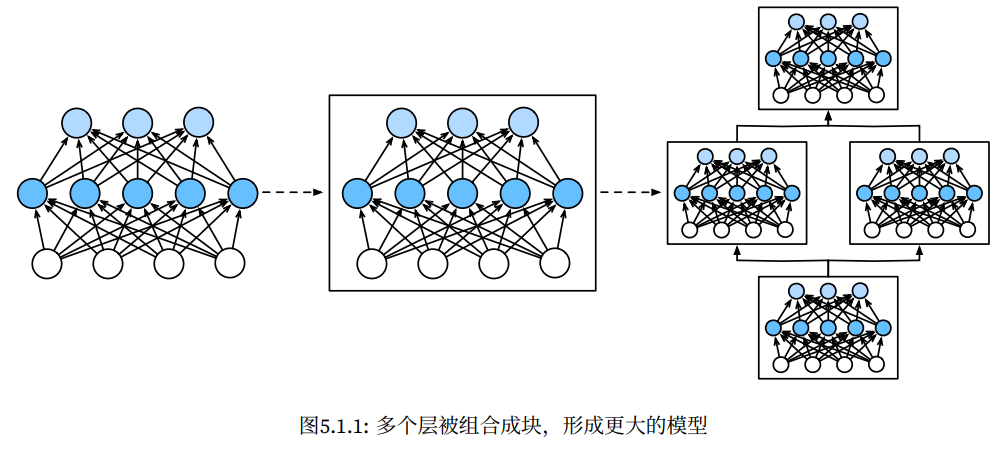

从编程的⻆度来看，块由类（class）表⽰。它的任何⼦类都必须定义⼀个将其输⼊转换为输出的前向传播函
数，并且必须存储任何必需的参数。注意，有些块不需要任何参数。最后，为了计算梯度，块必须具有反向
传播函数。在定义我们⾃⼰的块时，由于⾃动微分提供了⼀些后端实现，我们只需要考
虑前向传播函数和必需的参数。  

在构造⾃定义块之前，我们先回顾⼀下多层感知机代码。下⾯的代码⽣成⼀个⽹络，其中包含⼀
个具有256个单元和ReLU激活函数的全连接隐藏层，然后是⼀个具有10个隐藏单元且不带激活函数的全连接
输出层。

激活函数：所谓激活函数（Activation Function），就是在人工神经网络的神经元上运行的函数，负责将神经元的输入映射到输出端。激活函数（Activation functions）对于人工神经网络模型去学习、理解非常复杂和非线性的函数来说具有十分重要的作用。它们将非线性特性引入到我们的网络中。在神经元中，输入的 inputs 通过加权，求和后，还被作用了一个函数，这个函数就是激活函数。引入激活函数是为了增加神经网络模型的非线性。没有激活函数的每层都相当于矩阵相乘。就算你叠加了若干层之后，无非还是个矩阵相乘罢了。

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)

net(X)

tensor([[ 0.2067, -0.0112, -0.0321, -0.0550, -0.0950,  0.1251, -0.0516,  0.2008,
          0.0359,  0.0141],
        [ 0.1826,  0.0053, -0.0910,  0.0333, -0.0506,  0.1274, -0.0445,  0.1757,
          0.0334,  0.1157]], grad_fn=<AddmmBackward0>)

【说明】：在这个例⼦中，我们通过实例化nn.Sequential来构建我们的模型，层的执⾏顺序是作为参数传递的。简⽽⾔
之，nn.Sequential定义了⼀种特殊的Module，即在PyTorch中表⽰⼀个块的类，它维护了⼀个由Module组成
的有序列表。注意，两个全连接层都是Linear类的实例，Linear类本⾝就是Module的⼦类。另外，到⽬前为
⽌，我们⼀直在通过net(X)调⽤我们的模型来获得模型的输出。这实际上是net.__call__(X)的简写。这个前
向传播函数⾮常简单：它将列表中的每个块连接在⼀起，将每个块的输出作为下⼀个块的输⼊。


### 自定义层
要想直观地了解块是如何⼯作的，最简单的⽅法就是⾃⼰实现⼀个。在实现我们⾃定义块之前，我们简要总
结⼀下每个块必须提供的基本功能。  
* 将输⼊数据作为其前向传播函数的参数。
* 通过前向传播函数来⽣成输出。请注意，输出的形状可能与输⼊的形状不同。例如，我们上⾯模型中的第⼀个全连接的层接收⼀个20维的输⼊，但是返回⼀个维度为256的输出。
* 计算其输出关于输⼊的梯度，可通过其反向传播函数进⾏访问。通常这是⾃动发⽣的。
* 存储和访问前向传播计算所需的参数。
* 根据需要初始化模型参数。

在下⾯的代码⽚段中，它包含⼀个多层感知机，其具有256个隐藏单元的隐藏层和⼀
个10维输出层。注意，下⾯的MLP类继承了表⽰块的类。我们的实现只需要提供我们⾃⼰的构造函数（Python中
的__init__函数）和前向传播函数。


In [3]:
#定义一个多层感知机(MLP)类
class MLP(nn.Module):
    # ⽤模型参数声明层。这⾥，我们声明两个全连接的层
    def __init__(self):
        # 调⽤MLP的⽗类Module的构造函数来执⾏必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256) # 隐藏层
        self.out = nn.Linear(256, 10) # 输出层
    
    # 定义模型的前向传播，即如何根据输⼊X返回所需的模型输出
    def forward(self, X):
        # 注意，这⾥我们使⽤ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))



【说明】：⾸先看⼀下前向传播函数，它以X作为输⼊，计算带有激活函数的隐藏表⽰，并输出其未规范化的输出
值。在这个MLP实现中，两个层都是实例变量。要了解这为什么是合理的，可以想象实例化两个多层感知机
（net1和net2），并根据不同的数据对它们进⾏训练。当然，我们希望它们学到两种不同的模型。

接着我们实例化多层感知机的层，然后在每次调⽤前向传播函数时调⽤这些层。注意⼀些关键细节：⾸先，
我们定制的__init__函数通过super().__init__() 调⽤⽗类的__init__函数，省去了重复编写模版代码的痛
苦。然后，我们实例化两个全连接层，分别为self.hidden和self.out。注意，除⾮我们实现⼀个新的运算符，
否则我们不必担⼼反向传播函数或参数初始化，系统将⾃动⽣成这些。


In [4]:
#尝试一下这个函数
net = MLP()
net(X)


tensor([[-0.0420, -0.0159,  0.1816,  0.0289,  0.0173,  0.0104, -0.1703,  0.0826,
         -0.0190,  0.0496],
        [-0.0055, -0.1018,  0.1141,  0.0023,  0.0102,  0.0317, -0.1865,  0.0113,
         -0.0057,  0.0004]], grad_fn=<AddmmBackward0>)

块的⼀个主要优点是它的多功能性。我们可以⼦类化块以创建层（如全连接层的类）、整个模型（如上⾯
的MLP类）或具有中等复杂度的各种组件。我们在接下来的章节中充分利⽤了这种多功能性，⽐如在处理卷积
神经⽹络时。

### 顺序块
现在我们可以更仔细地看看Sequential类是如何⼯作的，回想⼀下Sequential的设计是为了把其他模块串起
来。为了构建我们⾃⼰的简化的MySequential，我们只需要定义两个关键函数：  
* ⼀种将块逐个追加到列表中的函数；
* ⼀种前向传播函数，⽤于将输⼊按追加块的顺序传递给块组成的“链条”。


In [5]:
#将其他模块串起来
class MySequential(nn.Module):
    
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这⾥，module是Module⼦类的⼀个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。_module的类型是OrderedDict
            self._modules[str(idx)] = module
    
    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X


【说明】：__init__函数将每个模块逐个添加到有序字典_modules中。读者可能会好奇为什么每个Module都有⼀
个_modules属性？以及为什么我们使⽤它⽽不是⾃⼰定义⼀个Python列表？简⽽⾔之，_modules的主要优
点是：在模块的参数初始化过程中，系统知道在_modules字典中查找需要初始化参数的⼦块。  

当MySequential的前向传播函数被调⽤时，每个添加的块都按照它们被添加的顺序执⾏。现在可以使⽤我们
的MySequential类重新实现多层感知机。



In [6]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

net(X)

tensor([[-0.0788, -0.0589, -0.1105,  0.0051,  0.0911, -0.0324, -0.1245,  0.1116,
          0.1337,  0.0290],
        [-0.1106, -0.0454, -0.2304, -0.0119,  0.0650, -0.0897, -0.1353,  0.0636,
          0.3123, -0.0953]], grad_fn=<AddmmBackward0>)

### 在前向传播函数中执行代码
Sequential类使模型构造变得简单，允许我们组合新的架构，⽽不必定义⾃⼰的类。然⽽，并不是所有的架
构都是简单的顺序架构。当需要更强的灵活性时，我们需要定义⾃⼰的块。例如，我们可能希望在前向传播
函数中执⾏Python的控制流。此外，我们可能希望执⾏任意的数学运算，⽽不是简单地依赖预定义的神经⽹
络层。  
到⽬前为⽌，我们⽹络中的所有操作都对⽹络的激活值及⽹络的参数起作⽤。然⽽，有时我们可能希望合并
既不是上⼀层的结果也不是可更新参数的项，我们称之为常数参数（constant parameter）。例如，我们需要
⼀个计算函数 f(x, w) = c · w⊤x的层，其中x是输⼊，w是参数，c是某个在优化过程中没有更新的指定常量。
因此我们实现了⼀个FixedHiddenMLP类，如下所⽰：  



In [7]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使⽤创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复⽤全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()




【说明】：在这个FixedHiddenMLP模型中，我们实现了⼀个隐藏层，其权重（self.rand_weight）在实例化时被随机初
始化，之后为常量。这个权重不是⼀个模型参数，因此它永远不会被反向传播更新。然后，神经⽹络将这个
固定层的输出通过⼀个全连接层。  

注意，在返回输出之前，模型做了⼀些不寻常的事情：它运⾏了⼀个while循环，在L1范数⼤于1的条件下，将
输出向量除以2，直到它满⾜条件为⽌。最后，模型返回了X中所有项的和。注意，此操作可能不会常⽤于在
任何实际任务中，我们只展⽰如何将任意代码集成到神经⽹络计算的流程中。

In [8]:
net = FixedHiddenMLP()
net(X)


tensor(0.2597, grad_fn=<SumBackward0>)

可以混合搭配各种组合块的⽅法。在下⾯的例⼦中，我们以⼀些想到的⽅法嵌套块。


In [9]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
        nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
    
    def forward(self, X):
        return self.linear(self.net(X))


chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)



tensor(0.2337, grad_fn=<SumBackward0>)

### 小结
* ⼀个块可以由许多层组成；⼀个块可以由许多块组成。
* 块可以包含代码。
* 块负责⼤量的内部处理，包括参数初始化和反向传播。
* 层和块的顺序连接由Sequential块处理。